In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from kNN import MyKNN

import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('./data-ori.csv', sep=',', nrows=1000)
df['SOURCE'] = df['SOURCE'].apply(lambda x: 0 if x == 'out' else 1)
df['SEX'] = df['SEX'].apply(lambda x: 0 if x == 'F' else 1)
target = df.pop('SOURCE')

scaler = StandardScaler()
df = scaler.fit_transform(df)
df

array([[-0.86563856, -0.7385081 , -0.39525262, ..., -0.83065607,
        -1.92681094, -1.00803226],
       [ 0.77014024,  0.88780351,  0.73920917, ..., -0.02359113,
        -1.92681094, -1.00803226],
       [-1.17721548, -1.00956004, -0.25727754, ..., -1.57563909,
        -1.92681094, -1.00803226],
       ...,
       [ 0.94540225,  1.21306583,  0.34061449, ...,  0.87659669,
         1.3141494 ,  0.99203175],
       [ 0.84803447,  0.77938274,  0.17197828, ...,  1.03180148,
         1.3141494 ,  0.99203175],
       [-0.37879963, -0.63008733,  2.10362944, ..., -3.25185088,
         1.3141494 ,  0.99203175]])

In [14]:
x, test_x, y, test_y = train_test_split(df, target.values, train_size=0.7)

In [15]:
my_model = MyKNN(k = 5, metric='minkowski', p=1, kernel='triangular')
my_model.fit(x, y)
my_forecast = my_model.predict(test_x)
accuracy_score(test_y, my_forecast)

0.81

# Hyperparameter optimization

### My model

In [16]:
import optuna
from sklearn.model_selection import cross_val_score

def my_model_objective(trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 5)
    else:
        p = trial.suggest_int('p', 2, 2)
    window = trial.suggest_categorical('fix_window', [True, False])
    if window:
        if metric == 'cosine':
            window_size = trial.suggest_float('window_size', 0.3, 1.5, step=0.1)
        else:
            window_size = trial.suggest_float('window_size', 20, 50, step=2)
        model = MyKNN(fix_window=window, window_size=window_size, metric=metric, p=p, kernel=kernel)
    else:
        k = trial.suggest_int('k', 1, 40)
        model = MyKNN(k=k, metric=metric, p=p, kernel=kernel)
    score = cross_val_score(model, x, y, scoring='accuracy', n_jobs=1)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(my_model_objective, n_trials=100)
my_best_params = study.best_params
study.best_trial

[I 2024-04-25 15:12:58,164] A new study created in memory with name: no-name-b1aa7087-b123-4849-b954-e9db78a9e47e
[I 2024-04-25 15:12:58,292] Trial 0 finished with value: 0.7928571428571429 and parameters: {'metric': 'minkowski', 'kernel': 'epanechnikov', 'p': 5, 'fix_window': False, 'k': 5}. Best is trial 0 with value: 0.7928571428571429.
[I 2024-04-25 15:12:58,380] Trial 1 finished with value: 0.7857142857142858 and parameters: {'metric': 'cosine', 'kernel': 'gaussian', 'p': 2, 'fix_window': False, 'k': 15}. Best is trial 0 with value: 0.7928571428571429.
[I 2024-04-25 15:12:58,518] Trial 2 finished with value: 0.7742857142857142 and parameters: {'metric': 'cosine', 'kernel': 'gaussian', 'p': 2, 'fix_window': False, 'k': 36}. Best is trial 0 with value: 0.7928571428571429.
[I 2024-04-25 15:12:58,600] Trial 3 finished with value: 0.7857142857142858 and parameters: {'metric': 'cosine', 'kernel': 'gaussian', 'p': 2, 'fix_window': False, 'k': 18}. Best is trial 0 with value: 0.7928571428

FrozenTrial(number=43, state=1, values=[0.8214285714285715], datetime_start=datetime.datetime(2024, 4, 25, 15, 13, 9, 729294), datetime_complete=datetime.datetime(2024, 4, 25, 15, 13, 9, 895470), params={'metric': 'minkowski', 'kernel': 'triangular', 'p': 3, 'fix_window': False, 'k': 19}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'metric': CategoricalDistribution(choices=('minkowski', 'cosine', 'chebyshev')), 'kernel': CategoricalDistribution(choices=('uniform', 'triangular', 'epanechnikov', 'gaussian')), 'p': IntDistribution(high=5, log=False, low=1, step=1), 'fix_window': CategoricalDistribution(choices=(True, False)), 'k': IntDistribution(high=40, log=False, low=1, step=1)}, trial_id=43, value=None)

In [17]:
my_best_params

{'metric': 'minkowski',
 'kernel': 'triangular',
 'p': 3,
 'fix_window': False,
 'k': 19}

### Sklearn model

In [18]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

def skl_model_objective(trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 5)
    else:
        p = trial.suggest_int('p', 2, 2)
    window = trial.suggest_categorical('fix_window', [True, False])
    if window:
        if metric == 'cosine':
            window_size = trial.suggest_float('window_size', 0.3, 1.5, step=0.1)
        else:
            window_size = trial.suggest_float('window_size', 20, 50, step=2)
        model = RadiusNeighborsClassifier(radius=window_size, metric=metric, p=p, weights=weights)
    else:
        k = trial.suggest_int('k', 1, 40)
        model = KNeighborsClassifier(n_neighbors=k, metric=metric, p=p, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=1)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(skl_model_objective, n_trials=100)
skl_best_params = study.best_params
study.best_trial

[I 2024-04-25 15:13:22,479] A new study created in memory with name: no-name-dc397e8e-8175-431f-ba6b-f18b5c1e660f
[I 2024-04-25 15:13:22,537] Trial 0 finished with value: 0.6642857142857143 and parameters: {'metric': 'chebyshev', 'weights': 'distance', 'p': 2, 'fix_window': True, 'window_size': 50.0}. Best is trial 0 with value: 0.6642857142857143.
[I 2024-04-25 15:13:22,577] Trial 1 finished with value: 0.8114285714285714 and parameters: {'metric': 'cosine', 'weights': 'distance', 'p': 2, 'fix_window': False, 'k': 18}. Best is trial 1 with value: 0.8114285714285714.
[I 2024-04-25 15:13:22,636] Trial 2 finished with value: 0.6642857142857143 and parameters: {'metric': 'chebyshev', 'weights': 'distance', 'p': 2, 'fix_window': True, 'window_size': 22.0}. Best is trial 1 with value: 0.8114285714285714.
[I 2024-04-25 15:13:22,733] Trial 3 finished with value: 0.7785714285714285 and parameters: {'metric': 'chebyshev', 'weights': 'uniform', 'p': 2, 'fix_window': False, 'k': 20}. Best is tria

FrozenTrial(number=22, state=1, values=[0.8185714285714285], datetime_start=datetime.datetime(2024, 4, 25, 15, 13, 23, 975996), datetime_complete=datetime.datetime(2024, 4, 25, 15, 13, 24, 22623), params={'metric': 'cosine', 'weights': 'distance', 'p': 2, 'fix_window': False, 'k': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'metric': CategoricalDistribution(choices=('minkowski', 'cosine', 'chebyshev')), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': IntDistribution(high=2, log=False, low=2, step=1), 'fix_window': CategoricalDistribution(choices=(True, False)), 'k': IntDistribution(high=40, log=False, low=1, step=1)}, trial_id=22, value=None)

In [19]:
skl_best_params

{'metric': 'cosine',
 'weights': 'distance',
 'p': 2,
 'fix_window': False,
 'k': 16}

# Plotting the dependence of the error function on hyperparameters

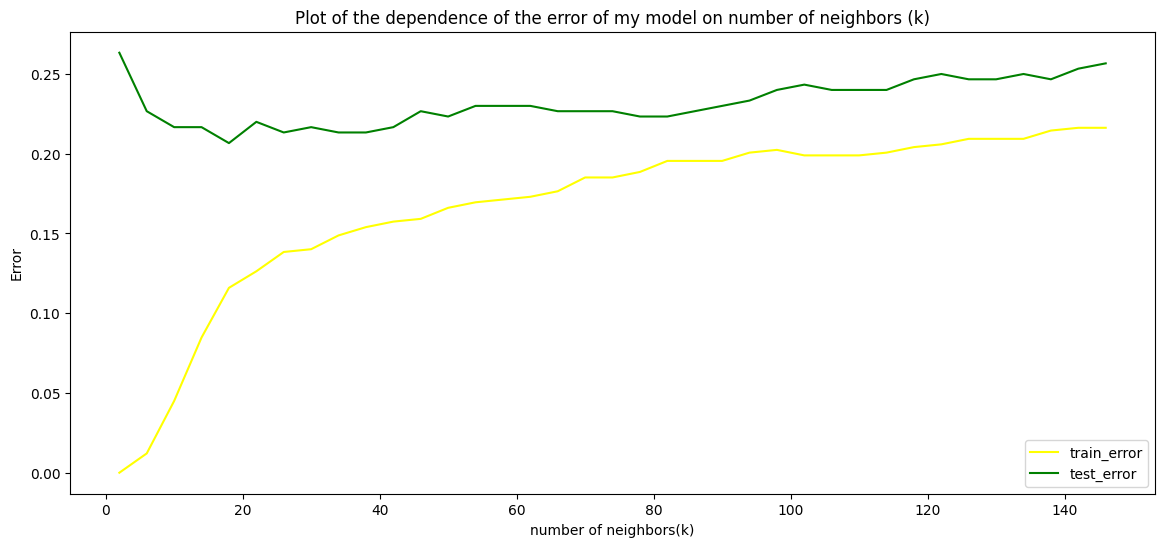

In [25]:
def train_test_error_plot(model_function, domain, title, x_label):
    train_error = []
    test_error = []
    for i in domain:
        model = model_function(i)
        model.fit(x, y)
        train_error.append(1 - accuracy_score(y, model.predict(x)))
        test_error.append(1 - accuracy_score(test_y, model.predict(test_x)))
            
    plt.figure(figsize=(14, 6))
    plt.plot(domain, train_error, color='yellow', label='train_error')
    plt.plot(domain, test_error, color='green', label='test_error')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Error")
    plt.legend()


if my_best_params["fix_window"]:
    if my_best_params["metric"] == 'cosine':
        train_test_error_plot(lambda h: MyKNN(fix_window=my_best_params["fix_window"], window_size=h, metric=my_best_params["metric"], p=my_best_params["p"], kernel=my_best_params["kernel"]), [i / 10 for i in range(3, 16)], "Plot of the dependence of the error of my model on window size", "window size")
    else:
        train_test_error_plot(lambda h: MyKNN(fix_window=my_best_params["fix_window"], window_size=h, metric=my_best_params["metric"], p=my_best_params["p"], kernel=my_best_params["kernel"]), range(20, 50, 2), "Plot of the dependence of the error of my model on window size", "window size")
else:
    train_test_error_plot(lambda k: MyKNN(fix_window=my_best_params["fix_window"], k=k, metric=my_best_params["metric"], p=my_best_params["p"], kernel=my_best_params["kernel"]), range(2, 150, 4), "Plot of the dependence of the error of my model on number of neighbors (k)", "number of neighbors(k)")
            

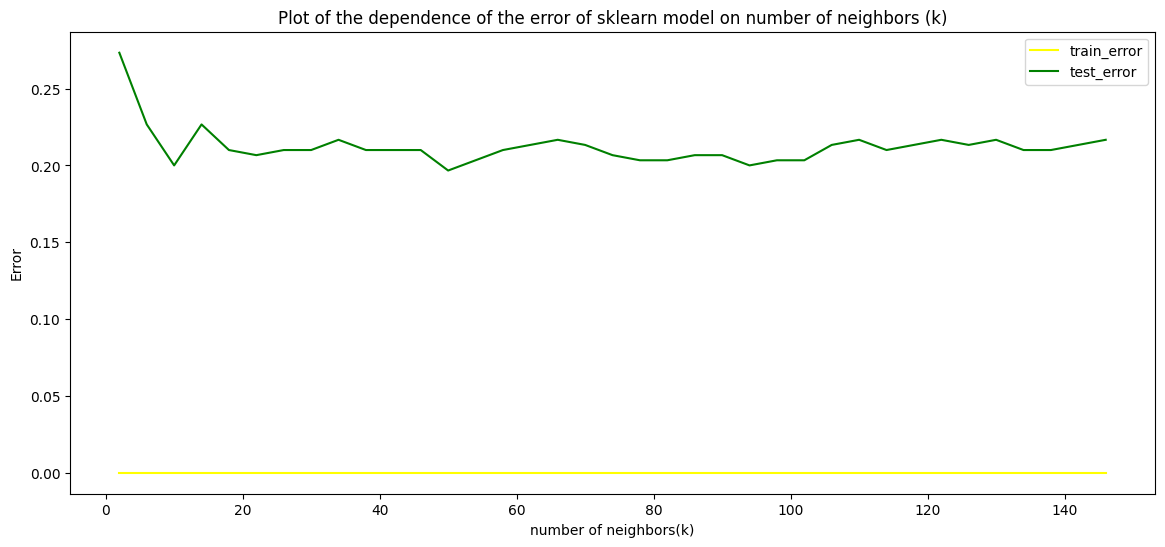

In [26]:
if skl_best_params["fix_window"]:
    if skl_best_params["metric"] == 'cosine':
        train_test_error_plot(lambda h: RadiusNeighborsClassifier(radius=h, metric=skl_best_params["metric"], p=skl_best_params["p"], weights=skl_best_params["weights"]), [i / 10 for i in range(3, 16)], "Plot of the dependence of the error of sklearn model on window size", "window size")
    else:
         train_test_error_plot(lambda h: RadiusNeighborsClassifier(radius=h, metric=skl_best_params["metric"], p=skl_best_params["p"], weights=skl_best_params["weights"]), range(20, 50, 2), "Plot of the dependence of the error of sklearn model on window size", "window size")
else:
    train_test_error_plot(lambda k: KNeighborsClassifier(n_neighbors=k, metric=skl_best_params["metric"], p=skl_best_params["p"], weights=skl_best_params["weights"]), range(2, 150, 4), "Plot of the dependence of the error of sklearn model on number of neighbors (k)", "number of neighbors(k)")

In [22]:
def lowess(model, x, y, w=0):
    weights = []
    for i in range(len(x)):
        model.fit(np.delete(x, i, axis=0), np.delete(y, i))
        a = model.predict([x[i]])
        if y[i] != a[0]:
            weight = w
        else:
            weight = 1
        weights.append(weight)
    return np.array(weights)

my_model = MyKNN(k = 22, metric='chebyshev', kernel='uniform')

my_model.fit(x, y)
my_forecast = my_model.predict(test_x)

my_weights = lowess(my_model, x, y, 0.05)
my_model.fit(x, y, weights_objects=my_weights)
my_forecast_lowess = my_model.predict(test_x)

print("Accuracy without using lowess: ", accuracy_score(test_y, my_forecast))
print("Accuracy with using lowess: ", accuracy_score(test_y, my_forecast_lowess))

Accuracy without using lowess:  0.75
Accuracy with using lowess:  0.7633333333333333


In [23]:
model = KNeighborsClassifier(n_neighbors=22, metric='chebyshev')

model.fit(x, y)
forecast = model.predict(test_x)
weights = lowess(my_model, x, y)

i = 0
while i < len(x):
    if weights[i] == 0:
        x = np.delete(x, i, axis = 0)
        y = np.delete(y, i)
    i += 1

model.fit(x, y)
forecast_lowess = model.predict(test_x)

print("Accuracy without using lowess: ", accuracy_score(test_y, forecast))
print("Accuracy with using lowess: ", accuracy_score(test_y, forecast_lowess))

Accuracy without using lowess:  0.75
Accuracy with using lowess:  0.77
